In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib
# matplotlib.use('agg')
# matplotlib.use('TkAgg')
# matplotlib.use('qtagg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                            AutoMinorLocator)
from math import *
#import pandas as pd

from scipy import interpolate
from scipy.optimize import curve_fit 

from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic
# import astropy.units as u
import astropy.units as units
import astropy.coordinates as coord
#from matplotlib.colors import LogNorm

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# #import matplotlib.ticker as mtick


import os
#%matplotlib widget
import seaborn as sns
import os, sys


# from astropy.io import ascii
# from astropy.coordinates import galactocentric_frame_defaults

import sklearn
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

from scipy import interpolate

import random
from scipy import integrate


gcolor = ['c','blue','g','r','orange', 'green','cyan']

In [2]:
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import sys,glob
from pathlib import Path

from ppxf.ppxf import ppxf, robust_sigma

from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins

from tqdm import tqdm  

In [3]:
def TB_reindex(TB_now):
    TB_now = TB_now.reset_index()
    TB_now = TB_now.drop(columns='index')
    return TB_now

In [4]:
def Data_Grouping(array_x, array_y, Group_K):
    Len = len(array_x)
    GP_num = int(Len/Group_K)
    if(Len%Group_K>0):
        GP_num += 1
    rt_x = []
    sig_x = []
    rt_y = []
    sig_y = []
    for i in range(GP_num):
        sum_x = []
        sum_y = []
        for t in range(Group_K):
            if((i*Group_K + t)< Len):
                sum_x += [array_x[i*Group_K + t]]
                sum_y += [array_y[i*Group_K + t]]
        rt_x += [np.mean(sum_x)]
        sig_x += [np.std(sum_x)]
        rt_y += [np.mean(sum_y)]
        sig_y += [np.std(sum_y)]

    return rt_x, rt_y, sig_x, sig_y

# Global Setting

In [5]:
c = 299792.458  # spped of light [km/s]

galaxy_name = 'VCC_1588'
spectrum_filename = 'VCC1588_stack.fits'
spectrum_z = 0.0042

# Data Pre-read

In [6]:
lam_range_temp = [4820, 5220]
redshift = spectrum_z           # redshift from
objfile = Path('./../Ori_Data/'+spectrum_filename)

In [7]:
# templates

sps_name = 'emiles'
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename

In [8]:
# vel_s = c * spectrum_z
vel_s = 0
vel_dis_s = 40 # Set the dis v = 40 km/s

In [9]:
## Code from example

class read_data_cube:
    def __init__(self, filename, lam_range, redshift):
        """Read data cube, de-redshift, log rebin and compute coordinates of each spaxel."""

        self.read_fits_file(filename)

        # Only use the specified rest-frame wavelength range
        wave = self.wave/(1 + redshift)      # de-redshift the spectrum
        w = (wave > lam_range[0]) & (wave < lam_range[1])
        wave = wave[w]
        cube = self.cube[w, ...]
        cubevar = self.cubevar[w, ...]

        signal = np.nanmedian(cube, 0)
        noise = np.sqrt(np.nanmedian(cubevar, 0))

        # Create coordinates centred on the brightest spaxel
        jm = np.argmax(signal)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*self.pixsize_x
        y = (row - row[jm])*self.pixsize_y

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1)        # create array of spectra [npix, nx*ny]
        variance = cubevar.reshape(npix, -1)    # create array of variance [npix, nx*ny]

        c = 299792.458  # speed of light in km/s
        velscale = np.min(c*np.diff(np.log(wave)))  # Preserve smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)

        # Coordinates and spectra only for spaxels with enough signal
        self.spectra = spectra
        self.variance = variance
        self.x = x
        self.y = y
        self.signal = signal.ravel()
        self.noise = noise.ravel()

        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.velscale = velscale
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = self.fwhm_gal/(1 + redshift)

        self.velfield = np.ndarray(shape=self.cube.shape[1:3])
        self.sigfield = np.ndarray(shape=self.cube.shape[1:3])

        # self.CD1_1 = self.CD1_1
        # self.CD1_2 = self.CD1_2
        # self.CD2_1 = self.CD2_1
        # self.CD2_2 = self.CD2_2
        # self.CRVAL1 = self.CRVAL1
        # self.CRVAL2 = self.CRVAL2

###############################################################################

    def read_fits_file(self, filename):
        """
        Read MUSE cube, noise, wavelength, spectral FWHM and pixel size.

        It must return the cube and cuberr as (npix, nx, ny) and wave as (npix,)

        IMPORTANT: This is not a general function! Its details depend on the
        way the data were stored in the FITS file and the available keywords in
        the FITS header. One may have to adapt the function to properly read
        the FITS file under analysis.                
        """

        Cut_LHS = 150
        Cut_RHS = 150

        hdu = fits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:] * (10 ** 18)
        # cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:]
        # cube = hdu[0].data * (10 ** 18)
        cubevar = np.empty_like(cube)  # This file contains no errors

        # Only use the specified rest-frame wavelength range
        wave = head['CRVAL3'] + head['CD3_3']*np.arange(cube.shape[0]) + head['CD3_3']*Cut_LHS

        self.cube = cube
        self.cubevar = cubevar
        self.wave = wave
        
        # self.fwhm_gal = 2.62  # Median FWHM = 2.62Å. Range: 2.51--2.88 (ESO instrument manual). 
        self.fwhm_gal = 1
        # self.pixsize = abs(head["CDELT1"])*3600    # 0.2"
        self.pixsize_x = abs(np.sqrt((head['CD1_1'])**2+(head['CD2_1'])**2))*3600
        self.pixsize_y = abs(np.sqrt((head['CD1_2'])**2+(head['CD2_2'])**2))*3600

        self.CD1_1 = head['CD1_1']
        self.CD1_2 = head['CD1_2']
        self.CD2_1 = head['CD2_1']
        self.CD2_2 = head['CD2_2']
        self.CRVAL1 = head['CRVAL1']
        self.CRVAL2 = head['CRVAL2']

In [10]:
Galaxy_info = read_data_cube(objfile, lam_range_temp, redshift)

In [11]:
Galaxy_P2P = pd.read_csv('./../FitData/'+galaxy_name+'_P2P_SFR.csv')
Galaxy_VNB = pd.read_csv('./../FitData/'+galaxy_name+'_VNB_SFR.csv')
Galaxy_RDB = pd.read_csv('./../FitData/'+galaxy_name+'_RDB_SFR.csv')

In [12]:
Galaxy_P2P['Index'] = Galaxy_P2P.index
Galaxy_VNB['Index'] = Galaxy_VNB.index
Galaxy_RDB['Index'] = Galaxy_RDB.index

In [13]:
Galaxy_VNB[:1]

,Unnamed: 0,H_beta_EL_value,H_beta_EL_ANR,O_3_5007_EL_value,O_3_5007_EL_ANR,Component_Sol,H_beta_SI,Mg_b_SI,Fe_5015_SI,R,SNR,K_index,Index
0,0,51.165719,43.145376,13.178465,8.306417,"[array([37.56761564, 20. ]), array([43....",2.580391,0.972212,1.061257,0.004969,24.058062,[ 696 697 698 699 700 701 702 703 704 ...,0


In [14]:
Galaxy_VNB['H_beta_EL_value'] = Galaxy_VNB['H_beta_EL_value']/(10**18)
Galaxy_VNB['O_3_5007_EL_value'] = Galaxy_VNB['O_3_5007_EL_value']/(10**18)
Galaxy_VNB['H_beta_SI'] = Galaxy_VNB['H_beta_SI']/(10**18)
Galaxy_VNB['Mg_b_SI'] = Galaxy_VNB['Mg_b_SI']/(10**18)
Galaxy_VNB['Fe_5015_SI'] = Galaxy_VNB['Fe_5015_SI']/(10**18)

Galaxy_RDB['H_beta_EL_value'] = Galaxy_RDB['H_beta_EL_value']/(10**18)
Galaxy_RDB['O_3_5007_EL_value'] = Galaxy_RDB['O_3_5007_EL_value']/(10**18)
Galaxy_RDB['H_beta_SI'] = Galaxy_RDB['H_beta_SI']/(10**18)
Galaxy_RDB['Mg_b_SI'] = Galaxy_RDB['Mg_b_SI']/(10**18)
Galaxy_RDB['Fe_5015_SI'] = Galaxy_RDB['Fe_5015_SI']/(10**18)

In [15]:
SNR_Lim = 7
Galaxy_P2P_HSNR = Galaxy_P2P[ Galaxy_P2P['SNR'] >  SNR_Lim]
Galaxy_VNB_HSNR = Galaxy_VNB[ Galaxy_VNB['SNR'] >  SNR_Lim]
Galaxy_RDB_HSNR = Galaxy_RDB[ Galaxy_RDB['SNR'] >  SNR_Lim]

Galaxy_P2P_HSNR = TB_reindex(Galaxy_P2P_HSNR)
Galaxy_VNB_HSNR = TB_reindex(Galaxy_VNB_HSNR)
Galaxy_RDB_HSNR = TB_reindex(Galaxy_RDB_HSNR)

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_16016\3561698675.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])


c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


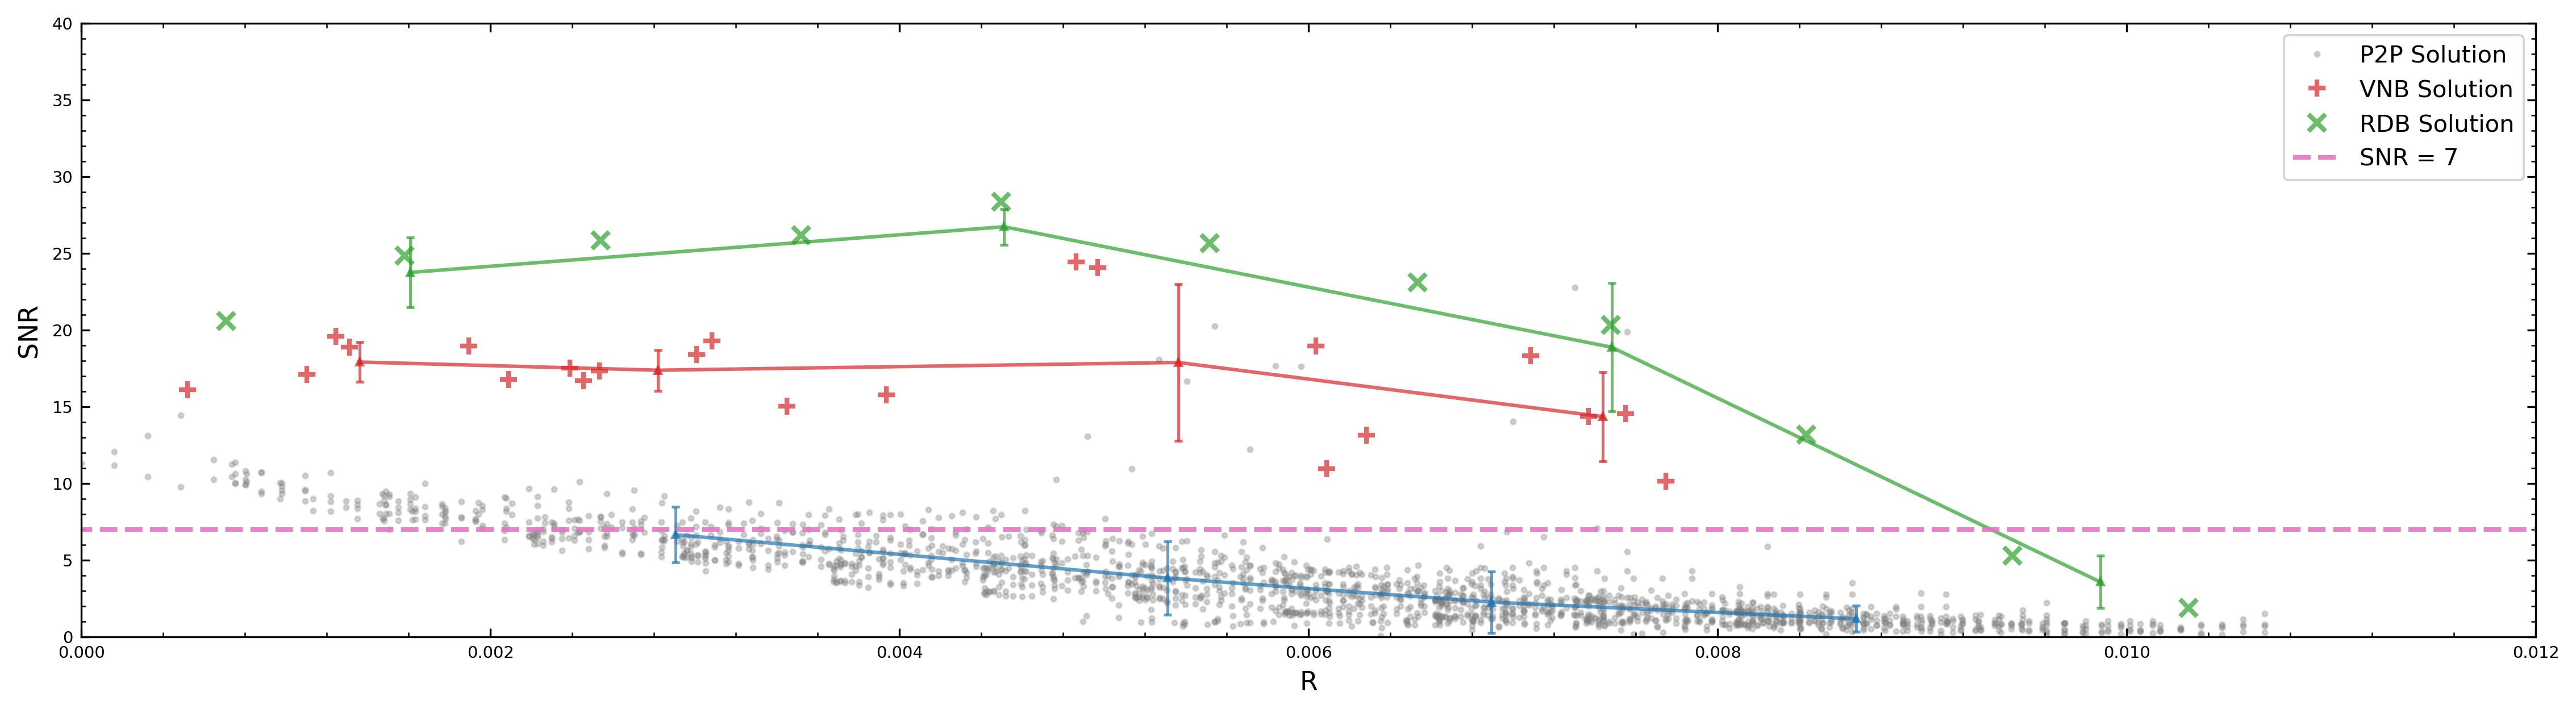

In [16]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(Galaxy_P2P['R'], Galaxy_P2P['SNR'], 'o', c='tab:gray', ms=2, mew=1, alpha=.3, label='P2P Solution', zorder=0)
ax1.plot(Galaxy_VNB['R'], Galaxy_VNB['SNR'], '+', c='tab:red', ms=7, mew=2, alpha=.7, label='VNB Solution')
ax1.plot(Galaxy_RDB['R'], Galaxy_RDB['SNR'], 'x', c='tab:green', ms=7, mew=2, alpha=.7, label='RDB Solution')

Galaxy_P2P_GP = Data_Grouping(array_x=np.array(Galaxy_P2P.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_P2P.sort_values(by=['R'])['SNR']), Group_K=501)
Galaxy_VNB_GP = Data_Grouping(array_x=np.array(Galaxy_VNB.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_VNB.sort_values(by=['R'])['SNR']), Group_K=6)
Galaxy_RDB_GP = Data_Grouping(array_x=np.array(Galaxy_RDB.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_RDB.sort_values(by=['R'])['SNR']), Group_K=3)

ax1.errorbar(Galaxy_P2P_GP[0], Galaxy_P2P_GP[1], yerr=Galaxy_P2P_GP[3],color='tab:blue',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)
ax1.errorbar(Galaxy_VNB_GP[0], Galaxy_VNB_GP[1], yerr=Galaxy_VNB_GP[3],color='tab:red',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7)
ax1.errorbar(Galaxy_RDB_GP[0], Galaxy_RDB_GP[1], yerr=Galaxy_RDB_GP[3],color='tab:green',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)

ax1.plot([-1,1], [SNR_Lim,SNR_Lim], '--', color='tab:pink', lw=2, alpha=.9, label='SNR = {:}'.format(SNR_Lim))

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax1.set_ylim(0,40)
ax1.set_xlim(0,0.012)

ax1.set_xlabel(r'R', size=11)
ax1.set_ylabel(r'SNR', size=11)

ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_16016\315344558.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])


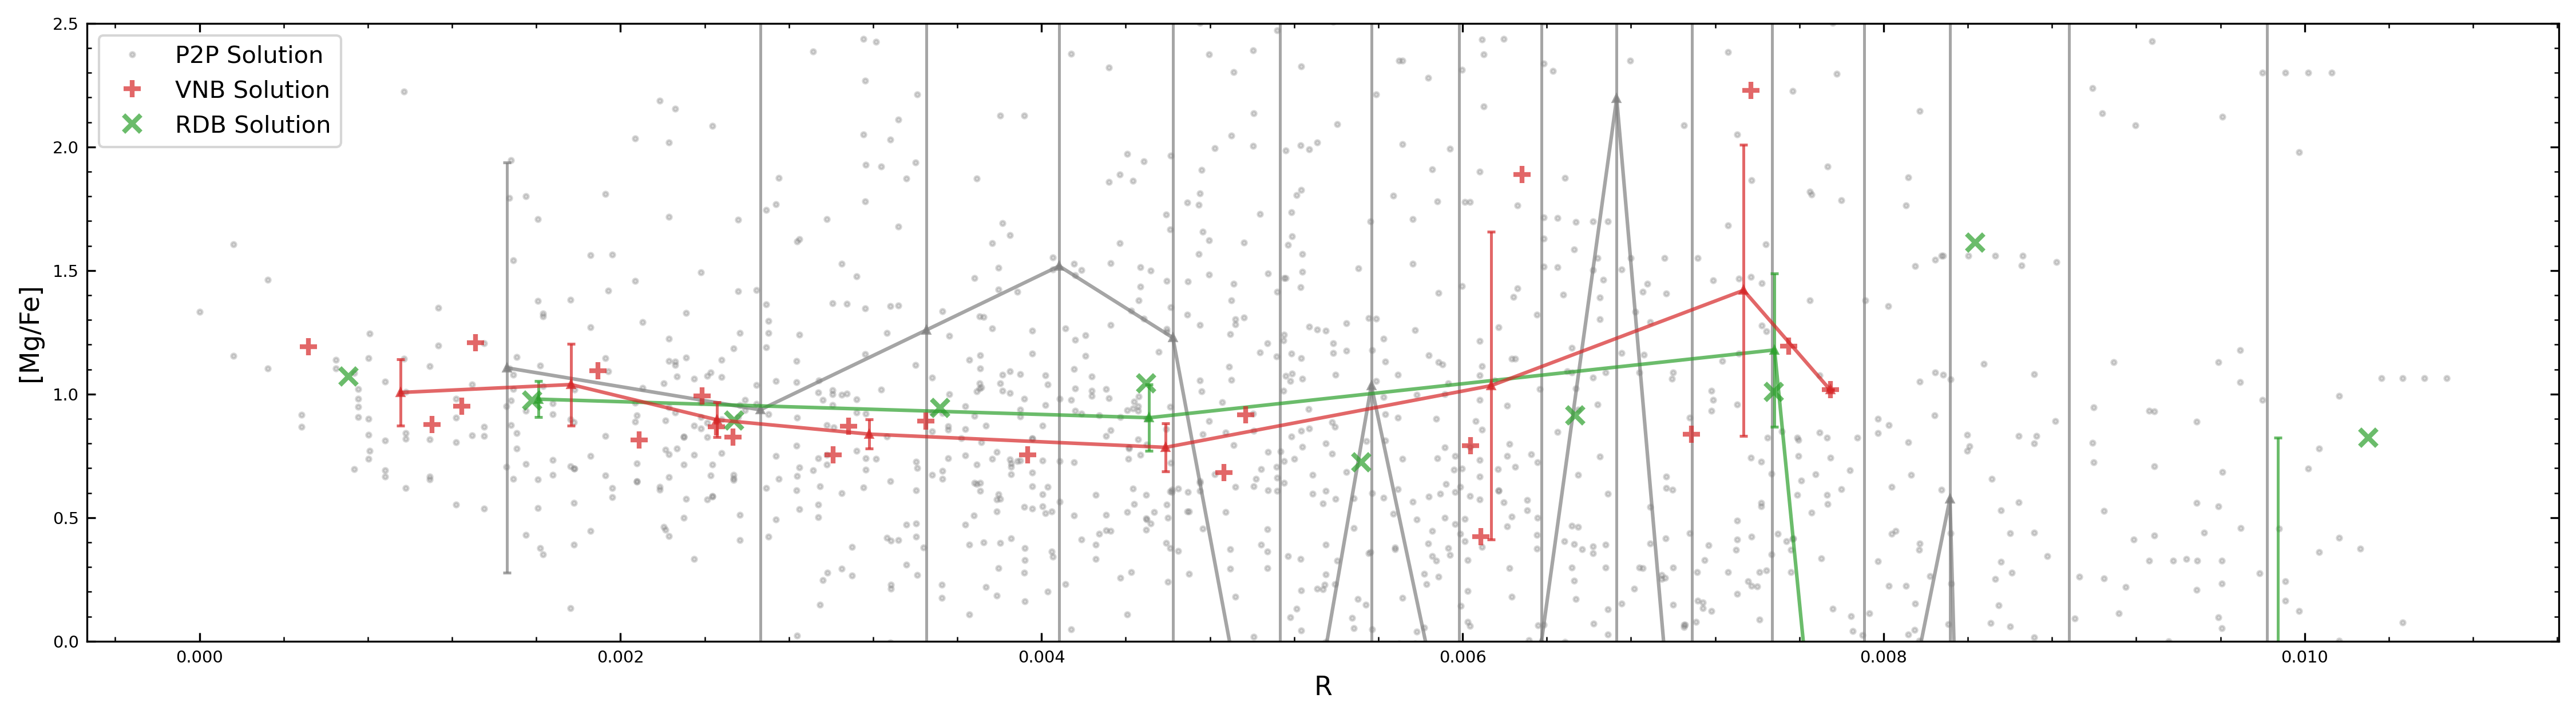

In [17]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(Galaxy_P2P['R'], Galaxy_P2P['Mg_b_SI']/Galaxy_P2P['Fe_5015_SI'], 'o', c='tab:gray', ms=2, mew=1, alpha=.3, label='P2P Solution', zorder=0)
ax1.plot(Galaxy_VNB['R'], Galaxy_VNB['Mg_b_SI']/Galaxy_VNB['Fe_5015_SI'], '+', c='tab:red', ms=7, mew=2, alpha=.7, label='VNB Solution')
ax1.plot(Galaxy_RDB['R'], Galaxy_RDB['Mg_b_SI']/Galaxy_RDB['Fe_5015_SI'], 'x', c='tab:green', ms=7, mew=2, alpha=.7, label='RDB Solution')

Galaxy_P2P_GP = Data_Grouping(array_x=np.array(Galaxy_P2P.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_P2P.sort_values(by=['R'])['Mg_b_SI']/Galaxy_P2P.sort_values(by=['R'])['Fe_5015_SI']), Group_K=126)
Galaxy_VNB_GP = Data_Grouping(array_x=np.array(Galaxy_VNB.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_VNB.sort_values(by=['R'])['Mg_b_SI']/Galaxy_VNB.sort_values(by=['R'])['Fe_5015_SI']), Group_K=3)
Galaxy_RDB_GP = Data_Grouping(array_x=np.array(Galaxy_RDB.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_RDB.sort_values(by=['R'])['Mg_b_SI']/Galaxy_RDB.sort_values(by=['R'])['Fe_5015_SI']), Group_K=3)

ax1.errorbar(Galaxy_P2P_GP[0], Galaxy_P2P_GP[1], yerr=Galaxy_P2P_GP[3],color='tab:gray',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)
ax1.errorbar(Galaxy_VNB_GP[0], Galaxy_VNB_GP[1], yerr=Galaxy_VNB_GP[3],color='tab:red',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7)
ax1.errorbar(Galaxy_RDB_GP[0], Galaxy_RDB_GP[1], yerr=Galaxy_RDB_GP[3],color='tab:green',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax1.set_ylim(0,2.5)
# ax1.set_xlim(,)
# ax1.set_yscale('log')
ax1.set_xlabel(r'R', size=11)
ax1.set_ylabel(r'[Mg/Fe]', size=11)

ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

In [18]:
MgFeR_Lim = 1.3

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_16016\1650429366.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])


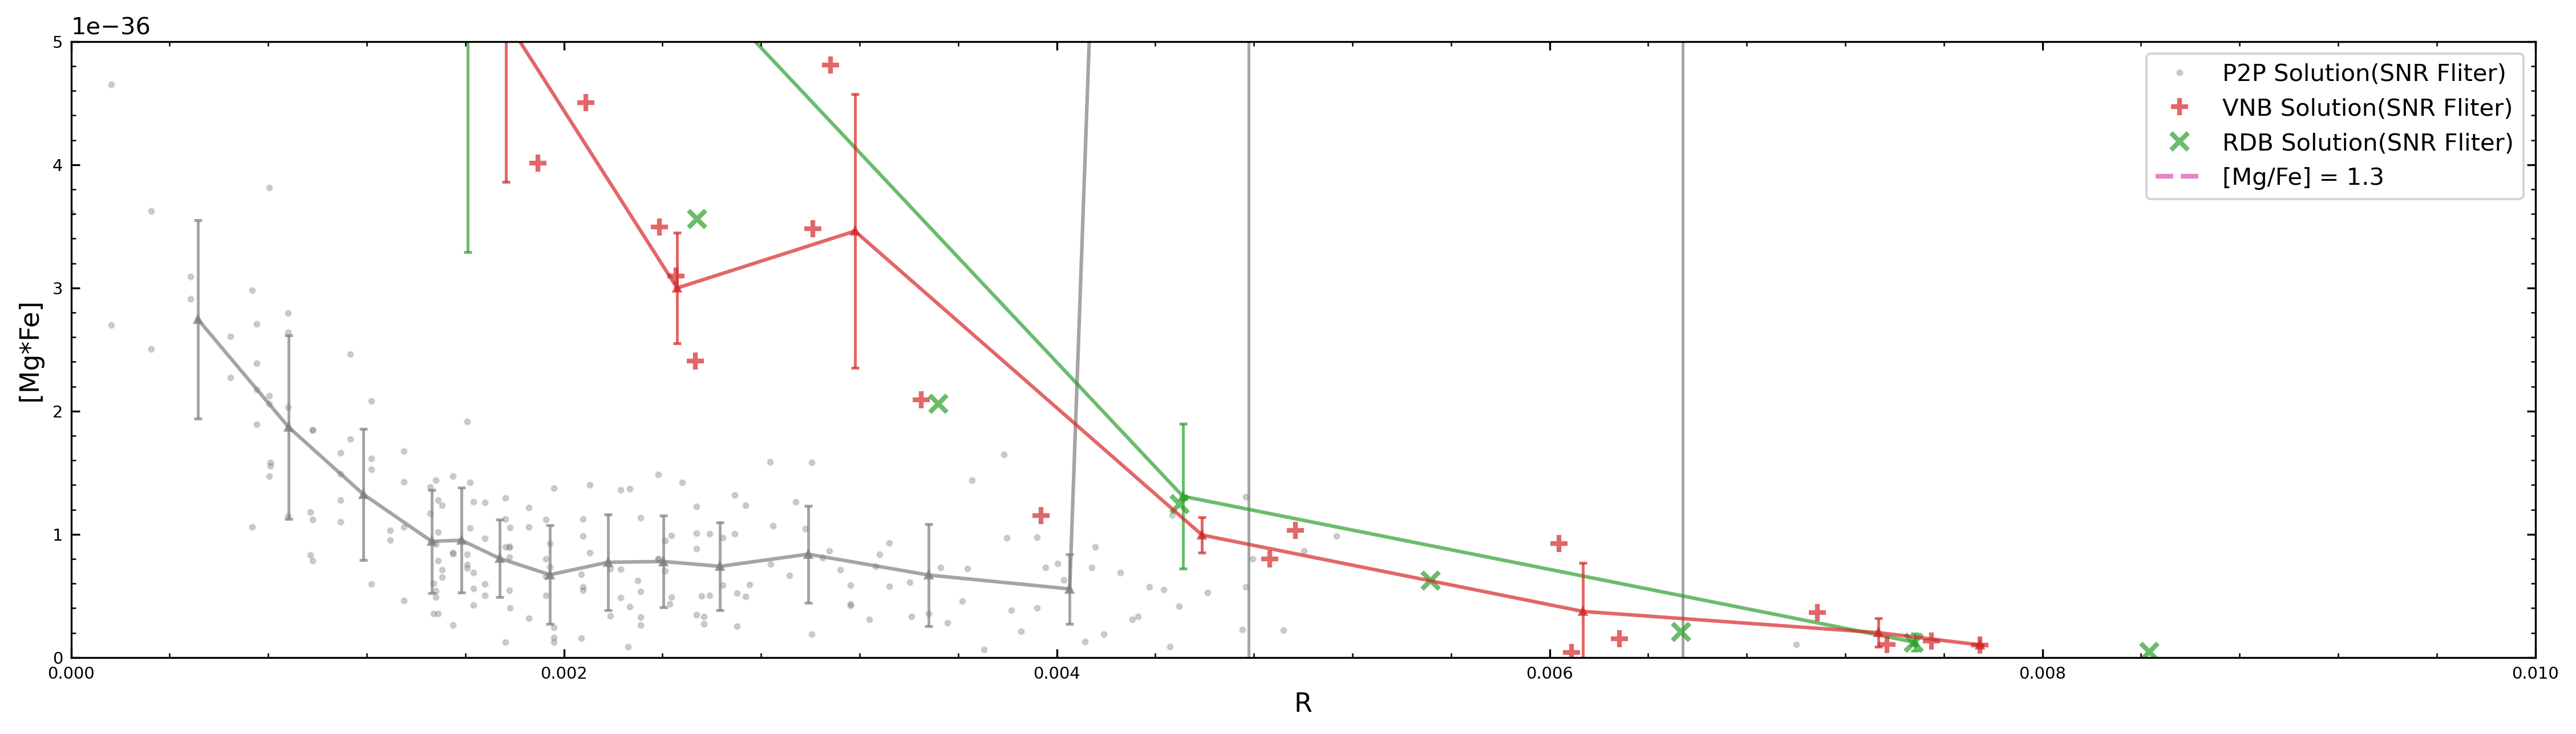

In [ ]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(Galaxy_P2P_HSNR['R'], Galaxy_P2P_HSNR['Mg_b_SI']*Galaxy_P2P_HSNR['Fe_5015_SI'], 'o', c='tab:gray', ms=2, mew=1, alpha=.3, label='P2P Solution(SNR Fliter)', zorder=0)
ax1.plot(Galaxy_VNB_HSNR['R'], Galaxy_VNB_HSNR['Mg_b_SI']*Galaxy_VNB_HSNR['Fe_5015_SI'], '+', c='tab:red', ms=7, mew=2, alpha=.7, label='VNB Solution(SNR Fliter)')
ax1.plot(Galaxy_RDB_HSNR['R'], Galaxy_RDB_HSNR['Mg_b_SI']*Galaxy_RDB_HSNR['Fe_5015_SI'], 'x', c='tab:green', ms=7, mew=2, alpha=.7, label='RDB Solution(SNR Fliter)')

Galaxy_P2P_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_P2P_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_P2P_HSNR.sort_values(by=['R'])['Mg_b_SI']*Galaxy_P2P_HSNR.sort_values(by=['R'])['Fe_5015_SI']), Group_K=15)
Galaxy_VNB_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_VNB_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_VNB_HSNR.sort_values(by=['R'])['Mg_b_SI']*Galaxy_VNB_HSNR.sort_values(by=['R'])['Fe_5015_SI']), Group_K=3)
Galaxy_RDB_GP_HSNR = Data_Grouping(array_x=np.array(Galaxy_RDB_HSNR.sort_values(by=['R'])['R']), array_y=np.array(Galaxy_RDB_HSNR.sort_values(by=['R'])['Mg_b_SI']*Galaxy_RDB_HSNR.sort_values(by=['R'])['Fe_5015_SI']), Group_K=3)

ax1.errorbar(Galaxy_P2P_GP_HSNR[0], Galaxy_P2P_GP_HSNR[1], yerr=Galaxy_P2P_GP_HSNR[3],color='tab:gray',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)
ax1.errorbar(Galaxy_VNB_GP_HSNR[0], Galaxy_VNB_GP_HSNR[1], yerr=Galaxy_VNB_GP_HSNR[3],color='tab:red',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7)
ax1.errorbar(Galaxy_RDB_GP_HSNR[0], Galaxy_RDB_GP_HSNR[1], yerr=Galaxy_RDB_GP_HSNR[3],color='tab:green',fmt='^-',ms=3,elinewidth=1.2,capsize=1.7,capthick=1.2,alpha=.7, zorder=1)

ax1.plot([-1,1], [MgFeR_Lim,MgFeR_Lim], '--', color='tab:pink', lw=2, alpha=.9, label='[Mg/Fe] = {:}'.format(MgFeR_Lim))

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax1.set_ylim(0,.5* (10**-35))
ax1.set_xlim(0,0.01)
# ax1.set_yscale('log')
ax1.set_xlabel(r'R', size=11)
ax1.set_ylabel(r'[Mg*Fe]', size=11)

ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_16016\2058016971.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_16016\2058016971.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('inferno')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_16016\2058016971.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_1 = mpl.cm.ScalarMappable(norm=norm_1, cmap=mpl.cm.get_cmap('inferno'))
C:\Users\VacEn-WenJin\AppDat

c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


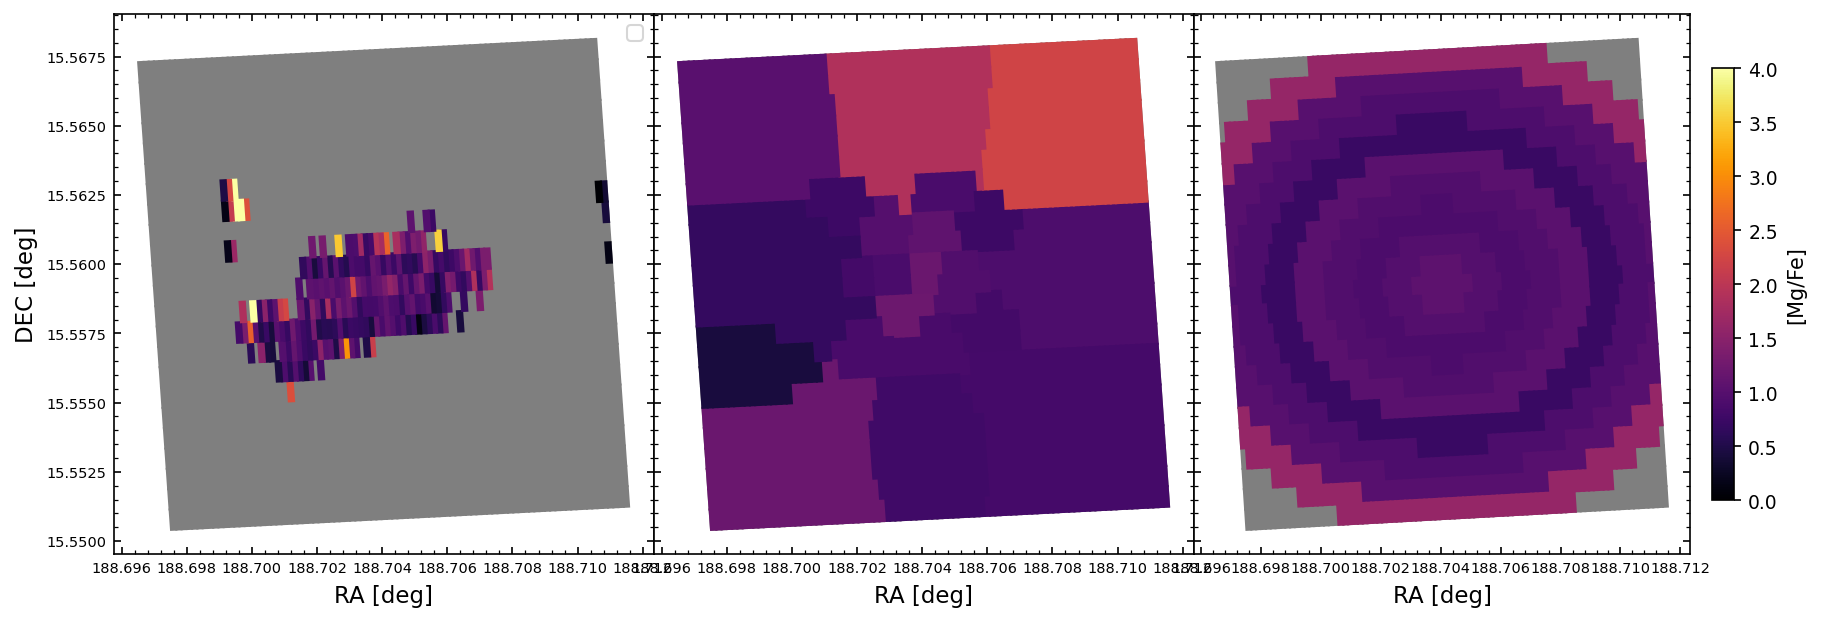

In [20]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(12,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.35, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0.35, right=.65, bottom=0.05, top=0.95, hspace=0.0)
ax2 = plt.subplot(gs2[0])

gs3 = gridspec.GridSpec(1, 1)
gs3.update(left=0.65, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax3 = plt.subplot(gs3[0])

LHS = 0
RHS = 4
cm1 = plt.cm.get_cmap('inferno')
norm_1 = mpl.colors.Normalize(vmin=LHS, vmax=RHS)
cmap_1 = mpl.cm.ScalarMappable(norm=norm_1, cmap=mpl.cm.get_cmap('inferno'))
cmap_1.set_array([])
cb1 = plt.colorbar(cmap_1,fraction=0.04,pad=0.04,shrink=0.9)

# -----------------------------------------------------------------------------------------------

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color='tab:gray')

for Index_num in range(len(Galaxy_P2P_HSNR)):
        POS_NL = (Galaxy_P2P_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_1.to_rgba(Galaxy_P2P_HSNR.loc[Index_num,'Mg_b_SI']/Galaxy_P2P_HSNR.loc[Index_num,'Fe_5015_SI']))

# -----------------------------------------------------------------------------------------------

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax2.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color='tab:gray')

for Index_num in range(len(Galaxy_VNB_HSNR)):
        POS_NL = (Galaxy_VNB_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax2.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_1.to_rgba(Galaxy_VNB_HSNR.loc[Index_num,'Mg_b_SI']/Galaxy_VNB_HSNR.loc[Index_num,'Fe_5015_SI']))

# -----------------------------------------------------------------------------------------------

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax3.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color='tab:gray')

for Index_num in range(len(Galaxy_RDB_HSNR)):
        POS_NL = (Galaxy_RDB_HSNR.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
                Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
                ax3.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                color=cmap_1.to_rgba(Galaxy_RDB_HSNR.loc[Index_num,'Mg_b_SI']/Galaxy_RDB_HSNR.loc[Index_num,'Fe_5015_SI']))

# -----------------------------------------------------------------------------------------------

ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
ax3.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax2.axes.yaxis.set_ticklabels([])
ax3.axes.yaxis.set_ticklabels([])
# ax2.axes.yaxis.set_label_position("right")

# ax1.set_ylim(0,2.5)
# ax1.set_xlim(0,0.01)
# ax1.set_yscale('log')
ax1.set_xlabel(r'RA [deg]', size=11)
ax2.set_xlabel(r'RA [deg]', size=11)
ax3.set_xlabel(r'RA [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'[Mg/Fe]')

ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

In [21]:
Galaxy_P2P_HSNR

,Unnamed: 0,H_beta_EL_value,H_beta_EL_ANR,O_3_5007_EL_value,O_3_5007_EL_ANR,Component_Sol,H_beta_SI,Mg_b_SI,Fe_5015_SI,R,SNR,K_index,Index
0,584,6.351084e-17,7.686467,1.137727e-17,1.017174,"[array([ 7.16428901, 20. ]), array([-9....",1.004674e-18,1.377687e-18,5.803838e-19,0.004795,7.234475,[584],584
1,665,2.080588e-17,2.566585,1.873791e-17,1.713644,"[array([ 3.04638815, 20. ]), array([ 0....",-2.666284e-18,6.128664e-19,7.473452e-19,0.003618,7.276647,[665],665
2,667,0.000000e+00,-0.000000,1.592217e-17,1.321319,"[array([-5.85184442, 20. ]), array([-4....",-3.294854e-18,6.231535e-19,6.145395e-19,0.003815,7.413826,[667],667
3,668,1.445951e-17,1.669380,8.514113e-18,0.723989,"[array([ 1.30599086, 20. ]), array([-29...",-3.260440e-18,3.894987e-19,1.036788e-18,0.003920,7.630520,[668],668
4,669,2.077457e-17,2.234330,1.059239e-17,0.852202,"[array([14.67221858, 20. ]), array([-36...",-2.977256e-18,6.271826e-19,1.003054e-18,0.004029,7.219074,[669],669
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,1376,1.300281e-16,0.514891,2.784463e-16,0.806959,"[array([-421.17844914, 158.2269874 ]), array(...",-3.917654e-18,3.303169e-17,1.579795e-17,0.005405,16.640524,[1376],1376
214,1377,1.342579e-16,1.083685,0.000000e+00,-0.000000,"[array([-339.21468808, 20. ]), array(...",6.586633e-18,3.407203e-18,2.313623e-17,0.005541,20.264210,[1377],1377
215,1462,0.000000e+00,0.000000,1.529069e-17,0.770656,"[array([-333.26588593, 246.55294944]), array(...",-3.065490e-18,7.246854e-18,1.426532e-18,0.005713,12.219308,[1462],1462
216,1463,0.000000e+00,0.000000,4.876670e-17,1.423310,"[array([-377.37930761, 118.77009168]), array(...",-4.676532e-18,9.827506e-18,4.310505e-18,0.005838,17.656360,[1463],1463


In [22]:
Galaxy_P2P.loc[1,'K_index']

'[1]'

In [23]:
Galaxy_P2P_HSNR[(Galaxy_P2P_HSNR['Mg_b_SI']/Galaxy_P2P_HSNR['Fe_5015_SI']) > 1.5]

,Unnamed: 0,H_beta_EL_value,H_beta_EL_ANR,O_3_5007_EL_value,O_3_5007_EL_ANR,Component_Sol,H_beta_SI,Mg_b_SI,Fe_5015_SI,R,SNR,K_index,Index
0,584,6.351084e-17,7.686467,1.137727e-17,1.017174,"[array([ 7.16428901, 20. ]), array([-9....",1.004674e-18,1.377687e-18,5.803838e-19,0.004795,7.234475,[584],584
9,742,3.328859e-18,0.418353,1.687694e-17,1.579185,"[array([ 1.93939957, 20. ]), array([48....",6.708411e-19,4.369819e-19,2.027553e-19,0.002260,7.017265,[742],742
13,747,7.333747e-17,9.133178,2.605562e-17,2.426383,"[array([34.20066546, 20. ]), array([-3....",1.056493e-18,1.230557e-18,4.038423e-19,0.002559,7.152814,[747],747
18,752,8.039566e-17,9.561435,1.121230e-17,0.995929,"[array([ 8.37320859, 20. ]), array([-2....",9.649930e-19,1.111541e-18,7.274356e-19,0.003050,7.474180,[752],752
28,763,5.931282e-17,7.875949,1.834839e-17,1.811250,"[array([-5.09841086, 20. ]), array([-0....",8.447064e-19,1.323525e-18,8.741343e-19,0.004469,7.690667,[763],763
68,852,2.651880e-16,30.785025,2.758640e-17,2.357302,"[array([12.71509644, 20. ]), array([35....",-3.353657e-18,4.784507e-19,1.858419e-19,0.004460,8.227046,[852],852
96,924,1.181184e-16,13.898261,3.133831e-17,2.734929,"[array([ 3.61022391, 30.58370346]), array([10....",-4.250499e-19,1.202029e-18,6.641397e-19,0.001927,7.696708,[924],924
102,932,7.537589e-17,9.507343,2.237159e-17,2.093847,"[array([23.73101282, 20. ]), array([26....",9.526658e-20,9.762673e-19,4.303566e-19,0.003163,7.440405,[932],932
103,933,7.437036e-17,9.361217,2.115862e-17,1.972091,"[array([23.21471333, 23.7171927 ]), array([25....",2.124213e-19,1.399903e-18,6.635882e-19,0.003321,7.081675,[933],933
106,936,9.474934e-17,11.685859,2.094645e-17,1.928294,"[array([15.91401562, 20. ]), array([30....",-1.981053e-19,1.209998e-18,8.006650e-19,0.003796,7.973821,[936],936


In [24]:
len(Galaxy_VNB_HSNR)

22

In [25]:
Galaxy_RDB_GP

([0.0016095434446428665,
  0.0045113300892973,
  0.0074819932830612,
  0.00987169753089645],
 [0.979245929219328,
  0.9042457239100431,
  1.1784923244520848,
  -19.485399455564533],
 [0.0007482095314341042,
  0.0008159163585470282,
  0.0007756127892330415,
  0.0004301531611816496],
 [0.07250055420326147,
  0.1336378665127065,
  0.3101828338513335,
  20.309421584570693])